# MNIST
We shall train a small FashionMNIST convolutional neural network very quickly with second order methods.

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchzero as tz
import matplotlib.pyplot as plt
import tqdm
import numpy as np
from torchvision.datasets import FashionMNIST

train = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=True, download=True)
test = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=False, download=True)

In [3]:
def to_tensors(ds):
    inputs = []
    targets = []
    for input, target in ds:
        inputs.append(torch.tensor(np.array(input), dtype=torch.float32))
        targets.append(torch.tensor(np.array(target), dtype=torch.long))

    # znormalize
    inputs = torch.stack(inputs)
    inputs = (inputs - inputs.mean() / inputs.std())

    return inputs.cuda(), torch.stack(targets).cuda()

train_X, train_y = to_tensors(train)
test_X, test_y = to_tensors(test)

train_X.unsqueeze_(1)
test_X.unsqueeze_(1)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

Quasi-newton methods are feasible for objectives with under around 10,000 parameters, as long as optimization happens on a GPU for fast matrix multiplications. With over 5,000 parameters the update rule computation will become to slow down, so under 5,000 is the ideal spot.

For neural networks make sure to replace RELU with ELU or another smooth activation function, and if there is any normalization, it shouldn't have momentum (i.e. replace batch norm with group, layer or instance norm).

In [13]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 8, 6, 2)
        self.c2 = nn.Conv2d(8, 8, 6, 2)
        self.c3 = nn.Conv2d(8, 8, 4, 1)
        self.head = nn.Sequential(nn.Linear(8, 8), nn.ELU(), nn.Linear(8,10))

    def forward(self, x):
        x = F.elu(self.c1(x))
        x = F.elu(self.c2(x))
        x = F.elu(self.c3(x)).flatten(1,-1)
        return self.head(x)

print(TinyConvNet()(torch.randn(1,1,28,28)).shape)
count_params(TinyConvNet())

torch.Size([1, 10])


3802

In [ ]:
model = TinyConvNet().cuda()

opt = tz.Modular(
    model.parameters(),
    tz.m.ResetOnStuck(tz.m.LBFGS(), tol=1e-6), tz.m.Backtracking()
)

train_losses = []
test_losses = []
test_acc = []

def closure(backward=True):
    y_hat = model(train_X)
    loss = F.cross_entropy(y_hat, train_y)
    if backward:
        opt.zero_grad()
        loss.backward()

    # test loss
    with torch.no_grad():
        y_hat_test = model(test_X)
        test_loss = F.cross_entropy(y_hat_test, test_y)
        test_accuracy = (y_hat_test.argmax(-1) == test_y).float().mean()

    # log
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    test_acc.append(test_accuracy.item())

    return loss


max_evals = 1000
while True:
    loss = opt.step(closure)
    print(f'{loss = }, {opt.num_evaluations = }')
    if opt.num_evaluations > max_evals: break

loss = tensor(2.7467, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 3
loss = tensor(2.6192, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 5
loss = tensor(2.6031, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 7
loss = tensor(2.3501, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 9
loss = tensor(2.3064, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 11
loss = tensor(2.3029, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 13
loss = tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 15
loss = tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 17
loss = tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 19
loss = tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>), opt.num_evaluations = 23
loss = tensor(2.3027, device='cuda:0', grad_fn=<NllLossBackward0>), opt.nu

max(test_acc) = 0.8280999660491943


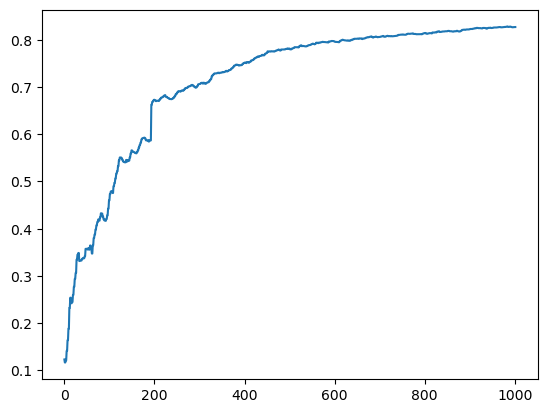

In [17]:
print(f"{max(test_acc) = }")
plt.plot(test_acc)